In [1]:
# -------------------------------------------------------
# 1. Imports & Configuration
# -------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib / Seaborn Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 12})


In [2]:
# -------------------------------------------------------
# 2. Define Constants / Paths
# -------------------------------------------------------
FILE_PATHS = {
    'nh_citations':     'data/final-csv/nh_citations.csv',
    'nh_ownership':     'data/final-csv/nh_ownership.csv',
    'nh_quality_mds':   'data/final-csv/nh_quality_mds.csv',
    'nh_survey':        'data/final-csv/nh_survey.csv',
    'pbj_non_nurse':    'data/final-csv/pbj_non_nurse.csv',
    'pbj_nurse':        'data/final-csv/pbj_nurse.csv',
    'qrp_provider':     'data/final-csv/qrp_provider.csv'
}

# Facility size bin definitions (used in multiple places)
SIZE_BINS = [0, 50, 104, 200, float('inf')]
SIZE_LABELS = ['Small', 'Medium', 'Large', 'Very Large']
SIZE_ORDER = ['Small', 'Medium', 'Large', 'Very Large']  # For consistent plotting



In [3]:
# -------------------------------------------------------
# 3. Read & Inspect Data
# -------------------------------------------------------
dfs = {}
for name, path in FILE_PATHS.items():
    dfs[name] = pd.read_csv(path, low_memory=False)

# # Optional: Quick checks of columns, dtypes, head
# for name, df in dfs.items():
#     print(f"\n--- {name} ---")
#     print("Columns:", df.columns.tolist())
#     print("Data Types:\n", df.dtypes)
#     print("Sample Rows:\n", df.head(3))

# Shortcut references
df_nh_citations   = dfs['nh_citations']
df_nh_ownership   = dfs['nh_ownership']
df_nh_quality_mds = dfs['nh_quality_mds']
df_nh_survey      = dfs['nh_survey']
df_pbj_non_nurse  = dfs['pbj_non_nurse']
df_pbj_nurse      = dfs['pbj_nurse']
df_qrp_provider   = dfs['qrp_provider']



In [4]:
# -------------------------------------------------------
# 4. Basic Facility Size Metrics
# -------------------------------------------------------
# Convert workdate columns to datetime (for nurse & non-nurse)
df_pbj_nurse['workdate']    = pd.to_datetime(df_pbj_nurse['workdate'])
df_pbj_non_nurse['workdate'] = pd.to_datetime(df_pbj_non_nurse['workdate'])

# Calculate average facility census (used for categorizing size)
facility_size = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .mean()
    .reset_index(name='mean_census')
)

facility_size['median_census'] = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .median()
    .values
)

facility_size['std_census'] = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .std()
    .values
)

# Create size categories
facility_size['size_category'] = pd.cut(
    facility_size['mean_census'],
    bins=SIZE_BINS,
    labels=SIZE_LABELS
)

print("\nFacility Size Stats:")
print(f"Number of facilities: {facility_size['provnum'].nunique()}")
print(f"Census range: {facility_size['mean_census'].min():.1f} to {facility_size['mean_census'].max():.1f}")



Facility Size Stats:
Number of facilities: 14564
Census range: 1.4 to 732.3


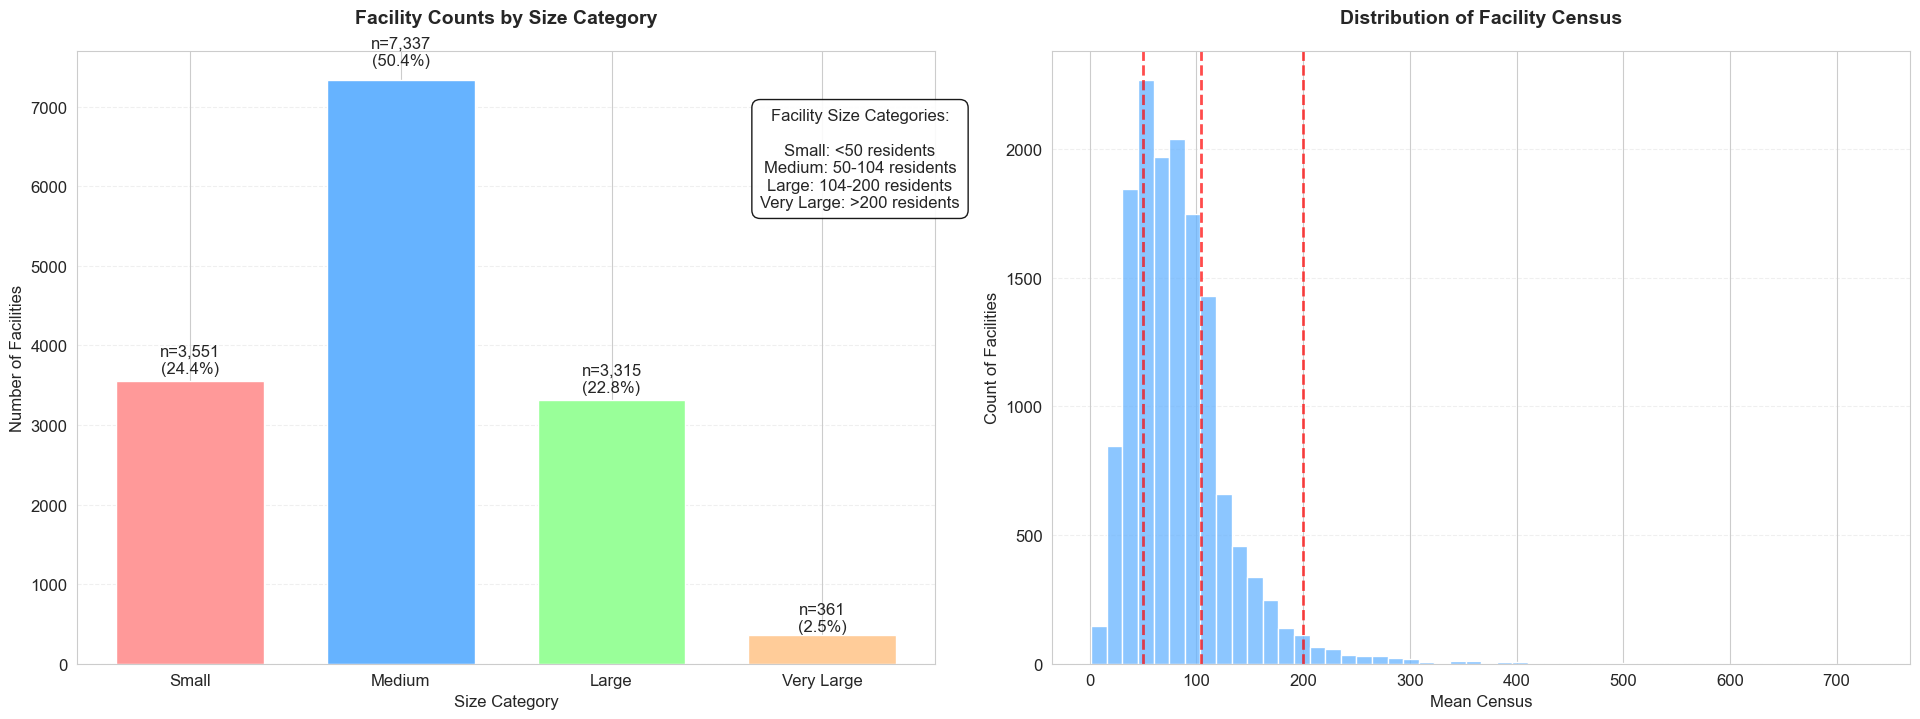

In [5]:
# -------------------------------------------------------
# 5. Visualizing Facility Size Distribution
# -------------------------------------------------------
fig = plt.figure(figsize=(20, 8))
gs = plt.GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])  # Bar chart
ax2 = fig.add_subplot(gs[0, 2:])   # Histogram

# Bar plot: exact counts & percentages
size_counts = facility_size['size_category'].value_counts().sort_index()
counts = size_counts.values
percentages = (counts / counts.sum()) * 100
# Using our consistent pastel color scheme
bar_colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']

# Enhanced bar plot with slightly larger bars
bars = ax1.bar(size_counts.index, counts, color=bar_colors, width=0.7)

# Enhanced data labels with better positioning and formatting
for bar, count, pct in zip(bars, counts, percentages):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + (height * 0.02),  # Dynamic padding based on height
        f'n={int(count):,}\n({pct:.1f}%)',  # Added thousands separator
        ha='center', va='bottom', 
        fontsize=12,
        fontweight='normal'
    )

# Enhanced left plot styling
ax1.set_title('Facility Counts by Size Category', fontsize=14, pad=20, fontweight='bold')
ax1.set_ylabel('Number of Facilities', fontsize=12)
ax1.set_xlabel('Size Category', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.3)  # Added subtle grid

# Enhanced histogram
sns.histplot(
    data=facility_size, 
    x='mean_census', 
    bins=50, 
    ax=ax2,
    color='#66B3FF'  # Using consistent color from our palette
)

# Enhanced boundary lines
for boundary in [50, 104, 200]:
    ax2.axvline(
        x=boundary, 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        alpha=0.7,
        label=f'Boundary: {boundary}'
    )

# Enhanced right plot styling
ax2.set_title('Distribution of Facility Census', fontsize=14, pad=20, fontweight='bold')
ax2.set_xlabel('Mean Census', fontsize=12)
ax2.set_ylabel('Count of Facilities', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.3)  # Added subtle grid

# Enhanced legend with better positioning and formatting
legend_text = (
    'Facility Size Categories:\n\n'
    'Small: <50 residents\n'
    'Medium: 50-104 residents\n'
    'Large: 104-200 residents\n'
    'Very Large: >200 residents'
)

fig.text(
    0.45, 0.75, legend_text,
    ha='center', va='center',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        alpha=0.9,
        boxstyle='round,pad=0.5'  # Added rounded corners
    ),
    fontsize=12
)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
# -------------------------------------------------------
# 6. Daily Ratios: Nursing & Support Staff
# -------------------------------------------------------
# Map size_category by provnum for quick lookup
size_mapping = facility_size.set_index('provnum')['size_category'].to_dict()

# Group nurse hours daily
daily_ratios = (
    df_pbj_nurse
    .groupby(['provnum', 'workdate'])
    .agg({
        'hrs_rn_ctr':  'sum',
        'hrs_rn_emp':  'sum',
        'hrs_lpn_ctr': 'sum',
        'hrs_lpn_emp': 'sum',
        'hrs_cna_ctr': 'sum',
        'hrs_cna_emp': 'sum'
    })
    .reset_index()
)

# Contract ratio calculations for RNs, LPNs, CNAs
daily_ratios['rn_daily_ratio'] = (
    daily_ratios['hrs_rn_ctr'] /
    (daily_ratios['hrs_rn_emp'] + daily_ratios['hrs_rn_ctr'] + 1e-6)
)

daily_ratios['lpn_daily_ratio'] = (
    daily_ratios['hrs_lpn_ctr'] /
    (daily_ratios['hrs_lpn_emp'] + daily_ratios['hrs_lpn_ctr'] + 1e-6)
)

daily_ratios['cna_daily_ratio'] = (
    daily_ratios['hrs_cna_ctr'] /
    (daily_ratios['hrs_cna_emp'] + daily_ratios['hrs_cna_ctr'] + 1e-6)
)

# Group support staff hours daily
support_hours = (
    df_pbj_non_nurse
    .groupby(['provnum', 'workdate'])
    .agg({
        col: 'sum'
        for col in df_pbj_non_nurse.columns
        if col.endswith(('_ctr', '_emp'))
    })
    .reset_index()
)

# Calculate overall support contract ratio
contract_cols = [col for col in support_hours.columns if col.endswith('_ctr')]
employee_cols = [col for col in support_hours.columns if col.endswith('_emp')]

daily_ratios['support_daily_ratio'] = (
    support_hours[contract_cols].sum(axis=1) /
    (support_hours[contract_cols].sum(axis=1) + support_hours[employee_cols].sum(axis=1) + 1e-6)
)

# Add day_of_week and size_category
daily_ratios['day_of_week']    = pd.to_datetime(daily_ratios['workdate']).dt.day_name()
daily_ratios['size_category']  = daily_ratios['provnum'].map(size_mapping)



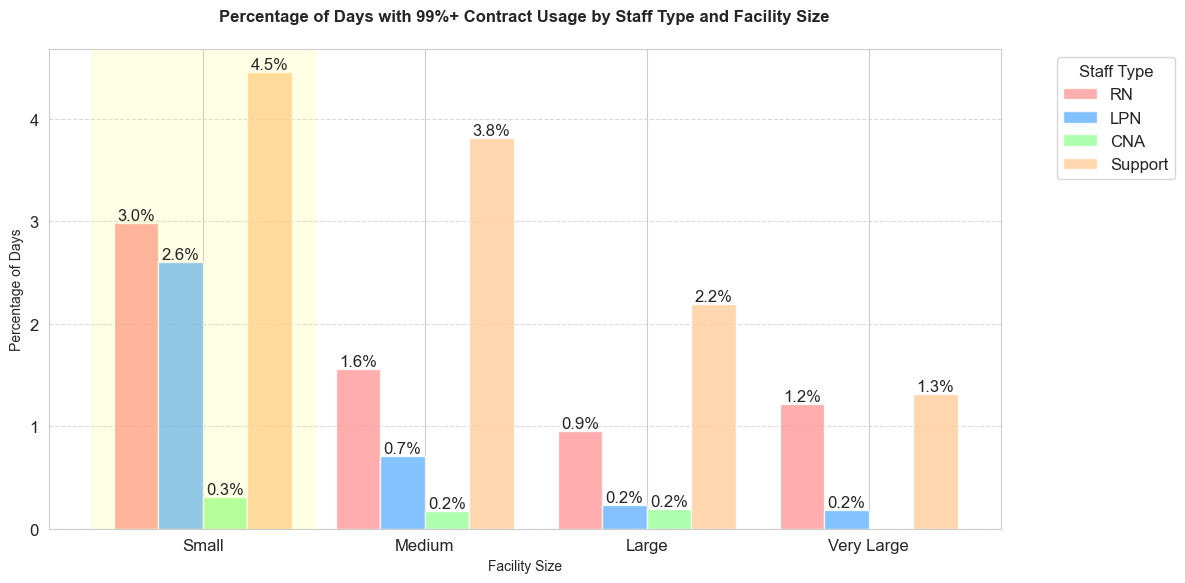

In [7]:
# -------------------------------------------------------
# 7. Percentage of Days with 99%+ Contract Usage
# -------------------------------------------------------
staff_types = {
    'rn_daily_ratio':     'RN',
    'lpn_daily_ratio':    'LPN',
    'cna_daily_ratio':    'CNA',
    'support_daily_ratio':'Support'
}

results_dict = {}
total_days   = daily_ratios.groupby('size_category').size()

for ratio_col, staff_name in staff_types.items():
    high_contract_days = (
        daily_ratios[daily_ratios[ratio_col] >= 0.99]
        .groupby('size_category')
        .size()
    )
    # Compute percentage; reindex for consistent size category order
    hc_percentage = (high_contract_days / total_days * 100).round(2).reindex(SIZE_ORDER)
    results_dict[staff_name] = hc_percentage

df_plot = pd.DataFrame(results_dict).T  # staff_name rows, size_category columns

# Plot
plt.figure(figsize=(12, 6))
bar_width = 0.2
positions = np.arange(len(SIZE_ORDER))
colors    = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

for idx, (staff_type, row) in enumerate(df_plot.iterrows()):
    offset = idx * bar_width
    bars   = plt.bar(positions + offset, row.values, bar_width, label=staff_type, color=colors[idx], alpha=0.8)
    # Add value labels
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            h,
            f'{h:.1f}%',
            ha='center', va='bottom'
        )

plt.title('Percentage of Days with 99%+ Contract Usage by Staff Type and Facility Size',
          pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Facility Size', fontsize=10)
plt.ylabel('Percentage of Days', fontsize=10)
plt.xticks(positions + bar_width * 1.5, SIZE_ORDER, rotation=0)
plt.legend(title='Staff Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Example highlight for small facilities
plt.axvspan(-0.2, 0.8, alpha=0.1, color='yellow', label='Small Facilities')
plt.tight_layout()
plt.show()



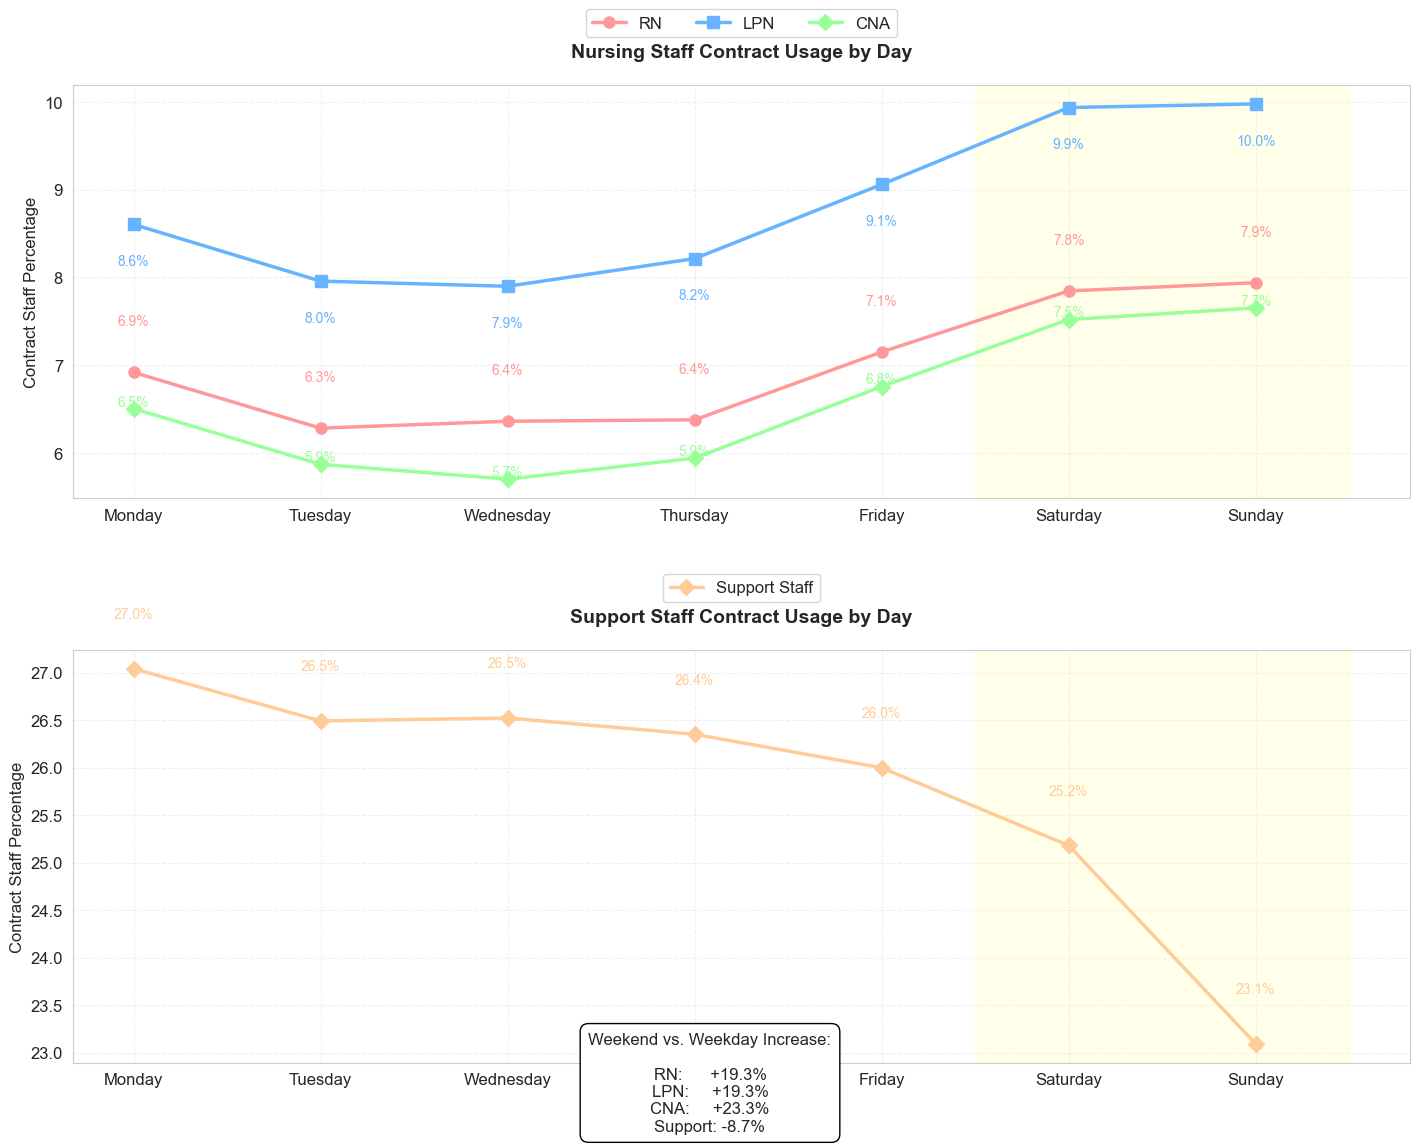

In [8]:
# -------------------------------------------------------
# 8. Day-of-Week Analysis: Contract vs. Weekend
# -------------------------------------------------------
# Day of week + weekend flags
for df_ in [df_pbj_nurse, df_pbj_non_nurse]:
    df_['workdate']   = pd.to_datetime(df_['workdate'])
    df_['day_of_week'] = df_['workdate'].dt.day_name()
    df_['is_weekend']  = df_['workdate'].dt.dayofweek.isin([5, 6])  # Sat=5, Sun=6

# Nursing staff contract ratio columns
df_pbj_nurse['total_rn_hours'] = df_pbj_nurse['hrs_rn_emp'] + df_pbj_nurse['hrs_rn_ctr']
df_pbj_nurse['rn_contract_ratio'] = df_pbj_nurse['hrs_rn_ctr'] / df_pbj_nurse['total_rn_hours']

df_pbj_nurse['total_lpn_hours'] = df_pbj_nurse['hrs_lpn_emp'] + df_pbj_nurse['hrs_lpn_ctr']
df_pbj_nurse['lpn_contract_ratio'] = df_pbj_nurse['hrs_lpn_ctr'] / df_pbj_nurse['total_lpn_hours']

df_pbj_nurse['total_cna_hours'] = df_pbj_nurse['hrs_cna_emp'] + df_pbj_nurse['hrs_cna_ctr']
df_pbj_nurse['cna_contract_ratio'] = df_pbj_nurse['hrs_cna_ctr'] / df_pbj_nurse['total_cna_hours']

# Support staff contract ratio columns
support_ctr_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_ctr')]
support_emp_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_emp')]
df_pbj_non_nurse['total_support_contract_hours'] = df_pbj_non_nurse[support_ctr_cols].sum(axis=1)
df_pbj_non_nurse['total_support_employee_hours'] = df_pbj_non_nurse[support_emp_cols].sum(axis=1)
df_pbj_non_nurse['total_support_hours'] = (
    df_pbj_non_nurse['total_support_contract_hours'] + df_pbj_non_nurse['total_support_employee_hours']
)
df_pbj_non_nurse['support_contract_ratio'] = (
    df_pbj_non_nurse['total_support_contract_hours'] / df_pbj_non_nurse['total_support_hours']
)

# Average ratio by day_of_week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

rn_daily = df_pbj_nurse.groupby('day_of_week')['rn_contract_ratio'].mean()
lpn_daily = df_pbj_nurse.groupby('day_of_week')['lpn_contract_ratio'].mean()
cna_daily = df_pbj_nurse.groupby('day_of_week')['cna_contract_ratio'].mean()
support_daily = df_pbj_non_nurse.groupby('day_of_week')['support_contract_ratio'].mean()

# Weekend vs. weekday masks
weekday_mask  = ~df_pbj_nurse['is_weekend']
weekend_mask  =  df_pbj_nurse['is_weekend']
support_weekday_mask = ~df_pbj_non_nurse['is_weekend']
support_weekend_mask =  df_pbj_non_nurse['is_weekend']

# Calculate the weekend increases
increases = {
    'RN': (
        df_pbj_nurse[weekend_mask]['rn_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['rn_contract_ratio'].mean() - 1
    ) * 100,
    'LPN': (
        df_pbj_nurse[weekend_mask]['lpn_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['lpn_contract_ratio'].mean() - 1
    ) * 100,
    'CNA': (
        df_pbj_nurse[weekend_mask]['cna_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['cna_contract_ratio'].mean() - 1
    ) * 100,
    'Support': (
        df_pbj_non_nurse[support_weekend_mask]['support_contract_ratio'].mean() /
        df_pbj_non_nurse[support_weekday_mask]['support_contract_ratio'].mean() - 1
    ) * 100
}

# Plot setup with original vertical layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Use our consistent pastel color palette
colors = {
    'RN':      '#FF9999',  # soft red
    'LPN':     '#66B3FF',  # soft blue
    'CNA':     '#99FF99',  # soft green
    'Support': '#FFCC99'   # soft orange
}

# Nursing staff plot with enhanced styling
for role, (data, marker) in zip(
    ['RN', 'LPN', 'CNA'],
    [(rn_daily, 'o'), (lpn_daily, 's'), (cna_daily, 'D')]
):
    line = ax1.plot(
        day_order, 
        data.reindex(day_order)*100,
        marker=marker,
        linewidth=2.5,
        markersize=8,
        color=colors[role],
        label=role
    )
    
    # Enhanced data labels
    for i, val in enumerate(data.reindex(day_order)*100):
        ax1.text(
            i, val + (0.5 if role == 'RN' else -0.5 if role == 'LPN' else 0),
            f'{val:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            color=colors[role]
        )

# Weekend highlight with our styling
ax1.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)  # Lighter yellow

# Enhanced title and labels
ax1.set_title('Nursing Staff Contract Usage by Day', fontsize=14, pad=20, fontweight='bold')
ax1.set_ylabel('Contract Staff Percentage', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(
    fontsize=12,
    bbox_to_anchor=(0.5, 1.15),
    loc='center',
    ncol=3,
    frameon=True
)

# Support staff plot with enhanced styling
ax2.plot(
    day_order,
    support_daily.reindex(day_order)*100,
    marker='D',
    linewidth=2.5,
    markersize=8,
    color=colors['Support'],
    label='Support Staff'
)

# Enhanced data labels for support staff
for i, val in enumerate(support_daily.reindex(day_order)*100):
    ax2.text(
        i, val + 0.5,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        color=colors['Support']
    )

# Weekend highlight
ax2.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)  # Lighter yellow

# Enhanced title and labels
ax2.set_title('Support Staff Contract Usage by Day', fontsize=14, pad=20, fontweight='bold')
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Contract Staff Percentage', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(
    fontsize=12,
    bbox_to_anchor=(0.5, 1.15),
    loc='center',
    frameon=True
)

# Add weekend increase information in a text box
increase_text = (
    'Weekend vs. Weekday Increase:\n\n'
    f'RN:      {increases["RN"]:+.1f}%\n'
    f'LPN:     {increases["LPN"]:+.1f}%\n'
    f'CNA:     {increases["CNA"]:+.1f}%\n'
    f'Support: {increases["Support"]:+.1f}%'
)

fig.text(
    0.5, 0.02,
    increase_text,
    ha='center',
    va='bottom',
    fontsize=12,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5'
    )
)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()



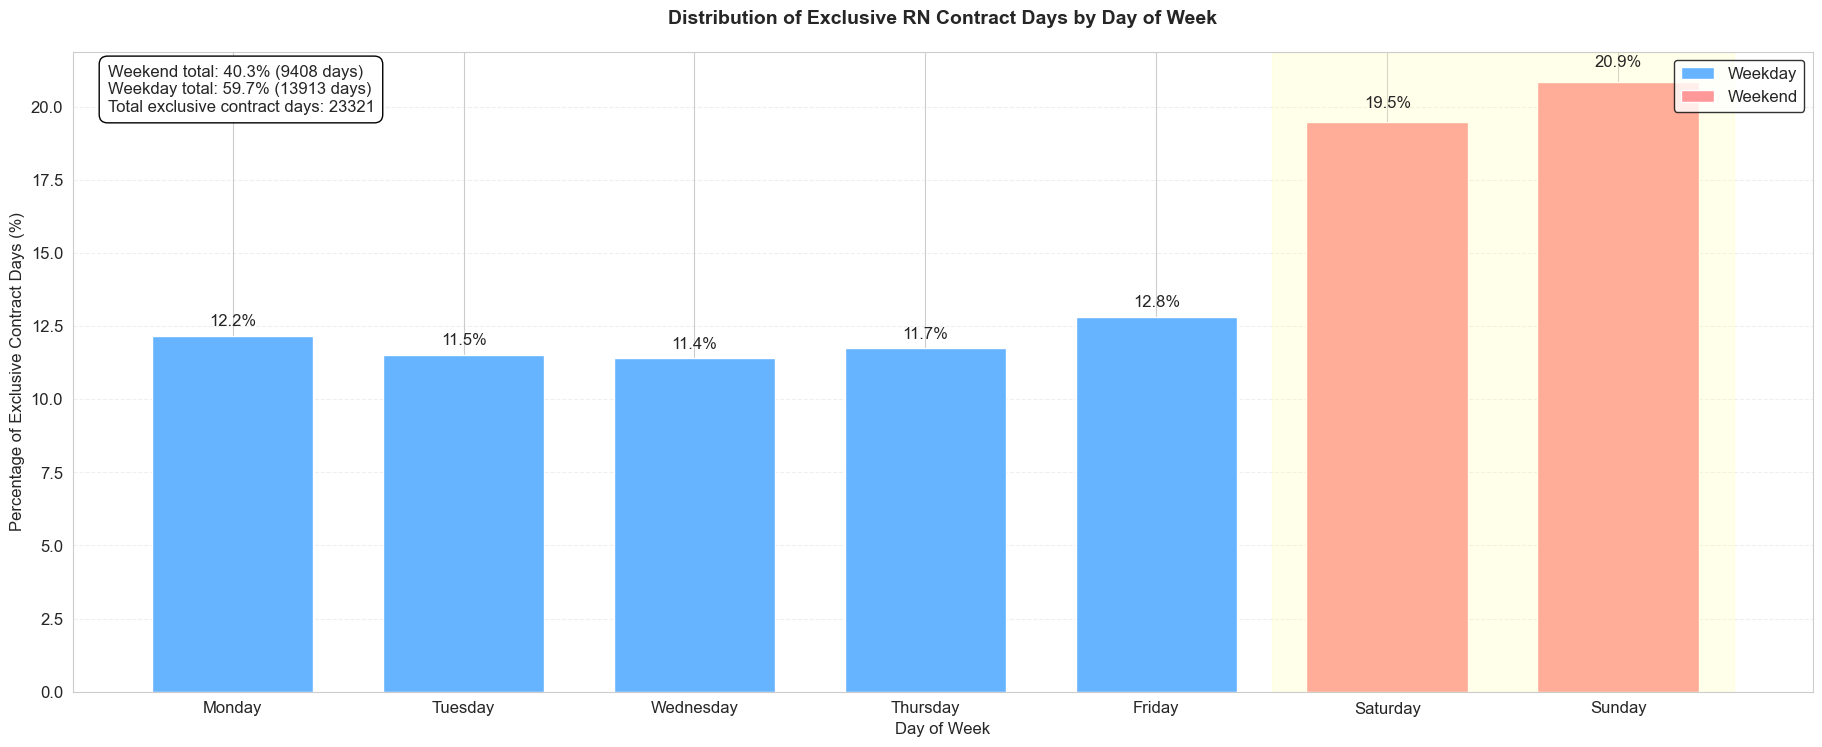

In [9]:
# -------------------------------------------------------
# 9. Exclusive RN Contract Staffing by Day of Week
# -------------------------------------------------------
from matplotlib.patches import Patch

exclusive_contract = df_pbj_nurse[
    (df_pbj_nurse['rn_contract_ratio'] >= 0.99) &
    (df_pbj_nurse['total_rn_hours'] > 0)
]

# Calculate distribution of exclusive contract days
exclusive_by_day = exclusive_contract.groupby('day_of_week').size()
percentage_by_day = (exclusive_by_day / exclusive_by_day.sum() * 100).round(2)
percentage_by_day = percentage_by_day.reindex(day_order)

# Create figure with our standard size
fig, ax = plt.subplots(figsize=(20, 8))

# Use our consistent pastel colors
weekday_color = '#66B3FF'  # soft blue
weekend_color = '#FF9999'  # soft red

# Create bars with enhanced styling
bars = ax.bar(
    range(len(day_order)),
    percentage_by_day.values,
    color=[
        weekday_color if d not in ['Saturday','Sunday']
        else weekend_color for d in day_order
    ],
    width=0.7
)

# Set x-axis labels
ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(day_order, fontsize=12)

# Enhanced title and labels
ax.set_title('Distribution of Exclusive RN Contract Days by Day of Week', 
             pad=20, fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage of Exclusive Contract Days (%)', fontsize=12)
ax.set_xlabel('Day of Week', fontsize=12)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Enhanced data labels
for idx, (bar, day) in enumerate(zip(bars, day_order)):
    height = bar.get_height()
    ax.text(
        idx,
        height + (height * 0.02),
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='normal'
    )

# Enhanced legend
legend_elements = [
    Patch(facecolor=weekday_color, label='Weekday'),
    Patch(facecolor=weekend_color, label='Weekend')
]
ax.legend(
    handles=legend_elements,
    fontsize=12,
    loc='upper right',
    frameon=True,
    edgecolor='black'
)

# Calculate summary statistics
weekend_pct = percentage_by_day[['Saturday', 'Sunday']].sum()
weekday_pct = percentage_by_day[['Monday','Tuesday','Wednesday','Thursday','Friday']].sum()
weekend_days = exclusive_by_day[['Saturday', 'Sunday']].sum()
weekday_days = exclusive_by_day[['Monday','Tuesday','Wednesday','Thursday','Friday']].sum()

# Create summary text
summary_text = (
    f"Weekend total: {weekend_pct:.1f}% ({weekend_days:.0f} days)\n"
    f"Weekday total: {weekday_pct:.1f}% ({weekday_days:.0f} days)\n"
    f"Total exclusive contract days: {exclusive_by_day.sum():.0f}"
)

# Add text box with summary statistics
plt.text(
    0.02, 0.98,
    summary_text,
    transform=ax.transAxes,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5'
    ),
    fontsize=12,
    verticalalignment='top'
)

# Highlight weekend with subtle background
ax.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)

# Adjust layout
plt.subplots_adjust(right=0.95, left=0.08, bottom=0.12, top=0.92)
plt.show()

C:\Users\paulo\AppData\Local\Temp\ipykernel_11444\3668158689.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exclusive_by_size = exclusive_contract_size.groupby('size_category').size()


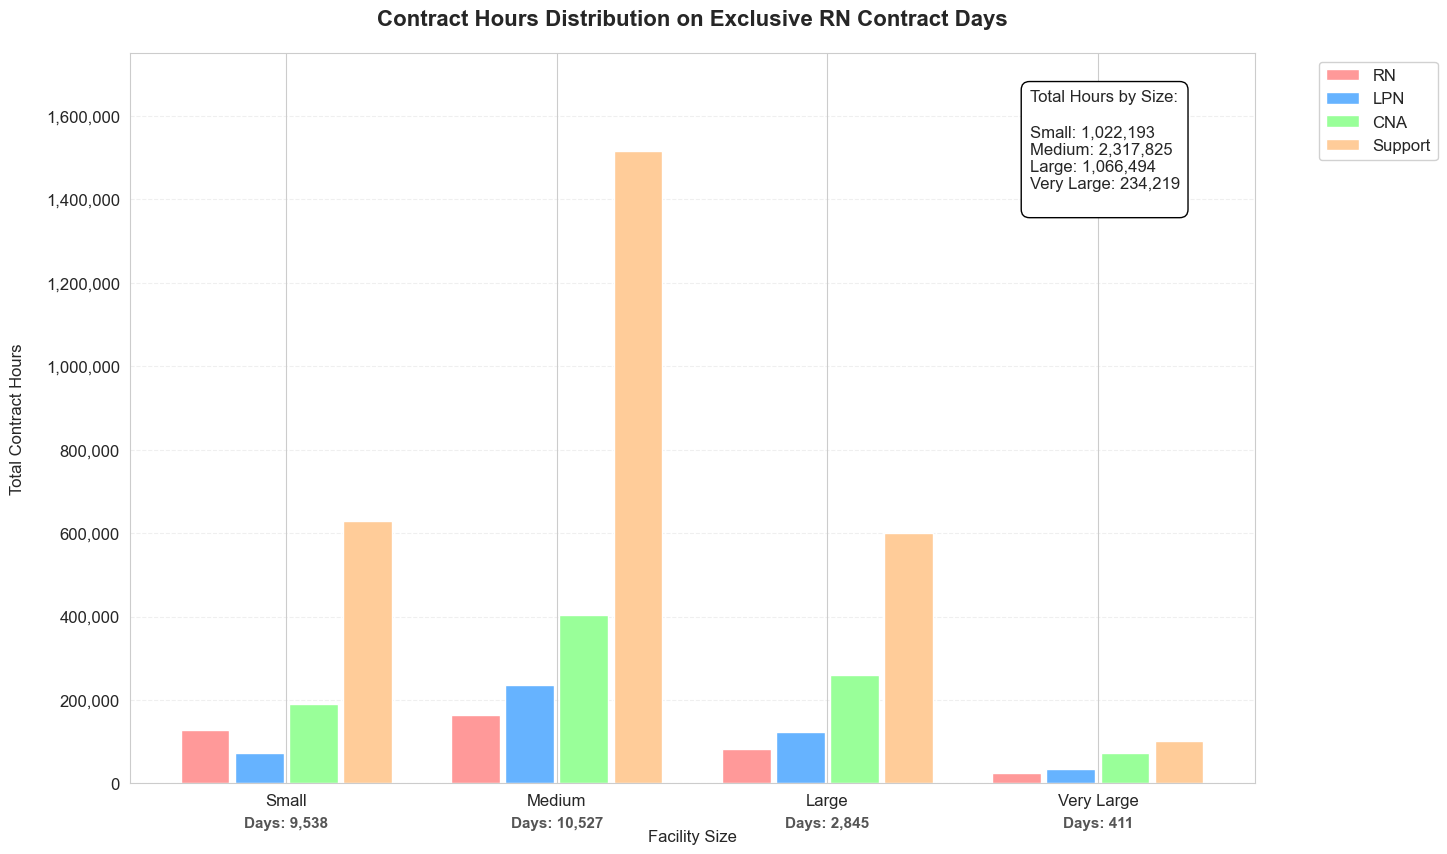

In [14]:
# -------------------------------------------------------
# Contract Hours Distribution on Exclusive RN Contract Days
# -------------------------------------------------------

# First, identify days where facilities used almost exclusively contract RNs (≥99% contract)
exclusive_contract = df_pbj_nurse[
    (df_pbj_nurse['rn_contract_ratio'] >= 0.99) &  # Filter for days with ≥99% RN contract staffing
    (df_pbj_nurse['total_rn_hours'] > 0)
]

# Add size categories to these exclusive RN contract days
exclusive_contract_size = exclusive_contract.copy()
exclusive_contract_size['size_category'] = pd.cut(
    exclusive_contract_size['mdscensus'],
    bins=SIZE_BINS,
    labels=SIZE_ORDER,
    include_lowest=True
)

# Count how many exclusive RN contract days each size category has
exclusive_by_size = exclusive_contract_size.groupby('size_category').size()

# Create data structure for the visualization
data = {
    'Size': SIZE_ORDER,
    'RN': [],
    'LPN': [],
    'CNA': [],
    'Support': []
}

# For each size category, calculate contract hours for ALL staff types
# but ONLY on days that were identified as exclusive RN contract days
for sz in SIZE_ORDER:
    # Get data for this size category
    size_data = exclusive_contract_size[exclusive_contract_size['size_category'] == sz]
    
    # Get the unique facilities and dates that had exclusive RN contract staffing
    exclusive_facilities = size_data['provnum'].unique()
    exclusive_dates = size_data['workdate'].unique()
    
    # Get support staff data for the same facilities and dates
    support_data = df_pbj_non_nurse[
        df_pbj_non_nurse['provnum'].isin(exclusive_facilities) &
        df_pbj_non_nurse['workdate'].isin(exclusive_dates)
    ]
    
    # Calculate contract hours for each staff type on these days
    data['RN'].append(size_data['hrs_rn_ctr'].sum())
    data['LPN'].append(size_data['hrs_lpn_ctr'].sum())
    data['CNA'].append(size_data['hrs_cna_ctr'].sum())
    support_ctr_cols = [c for c in support_data.columns if c.endswith('_ctr')]
    data['Support'].append(support_data[support_ctr_cols].sum().sum())

# Convert to DataFrame for easier plotting
df_hours = pd.DataFrame(data)

# Set up the figure with improved styling
fig, ax = plt.subplots(figsize=(15, 10))

# Define improved colors and staff types
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Soft pastel colors
staff_types = ['RN', 'LPN', 'CNA', 'Support']

# Calculate bar positions for side-by-side bars
n_staff = len(staff_types)
total_width = 0.8  # Total width for each group of bars
bar_width = total_width / n_staff
positions = np.arange(len(SIZE_ORDER))

# Create side-by-side bars
for i, (staff, color) in enumerate(zip(staff_types, colors)):
    # Calculate x positions for this group of bars
    x = positions + (i - n_staff/2 + 0.5) * bar_width
    values = df_hours[staff].values
    
    # Create bars with slight spacing
    bars = ax.bar(x, values, bar_width * 0.9, label=staff, color=color)

# Add number of days below each group of bars
for i, sz in enumerate(SIZE_ORDER):
    days = exclusive_by_size.get(sz, 0)
    ax.text(i, ax.get_ylim()[0] - (ax.get_ylim()[1] * 0.05),
            f'Days: {days:,}',
            ha='center', va='top',
            fontsize=11,
            fontweight='bold',
            color='#555555')

# Customize the chart appearance
ax.set_title('Contract Hours Distribution on Exclusive RN Contract Days',
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Facility Size', fontsize=12, labelpad=15)
ax.set_ylabel('Total Contract Hours', fontsize=12, labelpad=15)

# Set x-axis ticks
ax.set_xticks(positions)
ax.set_xticklabels(SIZE_ORDER)

# Improve grid appearance
ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
ax.set_axisbelow(True)

# Format y-axis labels with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Improve legend
legend = ax.legend(bbox_to_anchor=(1.05, 1),
                  loc='upper left',
                  fontsize=12,
                  frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Add extra space at the top for labels
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Create concise summary text
summary_text = "Total Hours by Size:\n\n"
for sz in SIZE_ORDER:
    total_hours = df_hours[df_hours['Size'] == sz][staff_types].sum().sum()
    summary_text += f"{sz}: {int(total_hours):,}\n"

# Add text box with summary statistics
plt.text(
    0.8, 0.95,  # Position in upper right
    summary_text,
    transform=ax.transAxes,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5'
    ),
    fontsize=12,
    verticalalignment='top'
)

# Adjust layout to accommodate legend and labels
plt.subplots_adjust(right=0.85, bottom=0.15, left=0.1)

plt.show()